In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import modgp
import GPflow




/home/paad/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#%% 
def logistic(x):
    return 1./(1+ np.exp(-x))

def softmax(x,y,z):
    Nor = np.exp(x) + np.exp(y) + np.exp(z)
    return np.exp(x)/Nor, np.exp(y)/Nor, np.exp(z)/Nor


In [3]:
#%%
X = np.linspace(0, 1, 100).reshape(-1, 1)
k1 = GPflow.kernels.Matern52(input_dim=1, lengthscales=0.1, variance=20)
k2 = GPflow.kernels.Matern52(input_dim=1, lengthscales=0.2, variance=20)
k4 = GPflow.kernels.Matern52(input_dim=1, lengthscales=0.15, variance=20)

frec = 5.0 #A0
k_i = GPflow.kernels.Cosine(input_dim = 1, variance=1.0,  lengthscales=1./(2*np.pi*frec))
k_j = GPflow.kernels.Cosine(input_dim = 1, variance=0.5,  lengthscales=1./(2*2*np.pi*frec))
k_l = GPflow.kernels.Cosine(input_dim = 1, variance=0.25, lengthscales=1./(3*2*np.pi*frec))
k3 = k_i + k_j + k_l

frec = 3.0 #A0
k_a = GPflow.kernels.Cosine(input_dim = 1, variance=1.0,  lengthscales=1./(2*np.pi*frec))
k_b = GPflow.kernels.Cosine(input_dim = 1, variance=0.5,  lengthscales=1./(2*2*np.pi*frec))
k_c = GPflow.kernels.Cosine(input_dim = 1, variance=0.25, lengthscales=1./(3*2*np.pi*frec))
k5 = k_a + k_b + k_c




#frec = 20.60 #E0
#k_a = GPflow.kernels.Cosine(input_dim = 1, variance=1.0,  lengthscales=1./(2*np.pi*frec))
#k_b = GPflow.kernels.Cosine(input_dim = 1, variance=0.5,  lengthscales=1./(2*2*np.pi*frec))
#k_c = GPflow.kernels.Cosine(input_dim = 1, variance=0.25, lengthscales=1./(3*2*np.pi*frec))
#k1 = k_a + k_b + k_c

#%%   
#2000
#X = np.linspace(0, 1, 2000).reshape(-1, 1) # (-1, 1) means any number of necessay rows and  1 column
#k1 = GPflow.kernels.Matern12(input_dim=1, lengthscales=0.01)
#k2 = GPflow.kernels.Matern52(input_dim=1, lengthscales=0.1, variance=10.)
#k3 = GPflow.kernels.Matern52(input_dim=1, lengthscales=1., variance=10.)



In [4]:
#%% calculate cov matrices
K1 = k1.compute_K_symm(X)
K2 = k2.compute_K_symm(X)
K3 = k3.compute_K_symm(X)
K4 = k4.compute_K_symm(X)
K5 = k5.compute_K_symm(X)



In [5]:
#%% sample f and g, transform g and generate the "observed" data y.
noise_var = 0.001
np.random.seed(1)
f  = np.random.multivariate_normal(np.zeros(X.shape[0]), K3).reshape(-1, 1)
f2 = np.random.multivariate_normal(np.zeros(X.shape[0]), K5).reshape(-1, 1)
g = np.random.multivariate_normal(np.zeros(X.shape[0]), K2).reshape(-1, 1)
h = np.random.multivariate_normal(np.zeros(X.shape[0]), K1).reshape(-1, 1)
k = np.random.multivariate_normal(np.zeros(X.shape[0]), K4).reshape(-1, 1)
#%%
g_softmax, h_softmax, k_softmax = softmax(g,h,k)
mean = f * g_softmax  + h_softmax*0 + f2*k_softmax
y = mean + np.random.randn(*mean.shape) * np.sqrt(noise_var)



/home/paad/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: covariance is not positive-semidefinite.
/home/paad/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: covariance is not positive-semidefinite.


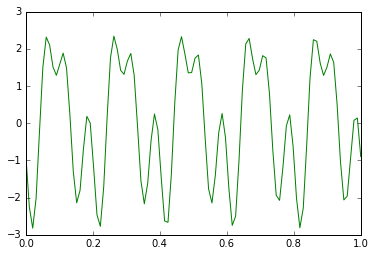

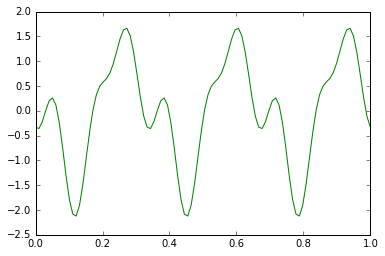

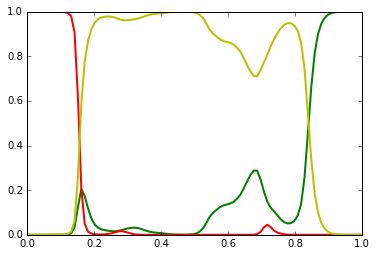

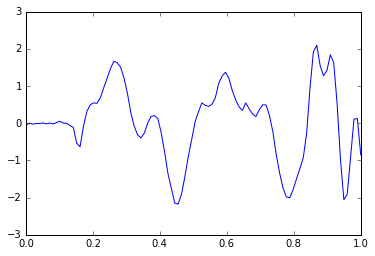

In [6]:
#%% plot the latent functions f(t) and \sigma(g(t)), plot the observed variable y(t)
plt.figure()
plt.plot(X, f, 'g', lw=1)

plt.figure()
plt.plot(X, f2, 'g', lw=1)

#%%
plt.figure()
#plt.figure()
plt.plot(X, g_softmax, 'g', lw=2)

#plt.figure()
plt.plot(X, h_softmax, 'r', lw=2)
#plt.twinx()

plt.plot(X, k_softmax, 'y', lw=2)
#plt.twinx()
#%%
plt.figure()
plt.plot(X, y, 'b')







In [7]:
#%% generate model object
Z = X[::10].copy() # copy inducting points from input vector X
m = modgp.ModGP(X, y, k3, k2, k1, k4, k5, Z) # X -> input variable, y -> observed data, k1,k2 -> kernels, Z -> inducting points



In [11]:
#%% keep model parameters fixed.
m.kern1.fixed = True
m.kern2.fixed = True
m.kern3.fixed = True
m.kern4.fixed = True
m.likelihood.noise_var = noise_var
m.likelihood.noise_var.fixed = True

#%% optimize the approximated distributions over f(t) and g(t).
m.optimize(disp=1,maxiter=4000)



Caught KeyboardInterrupt, setting                   model with most recent state.


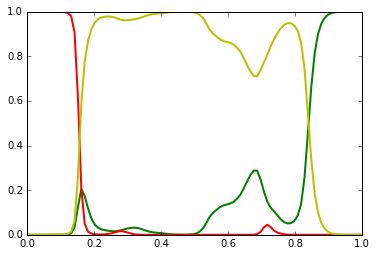

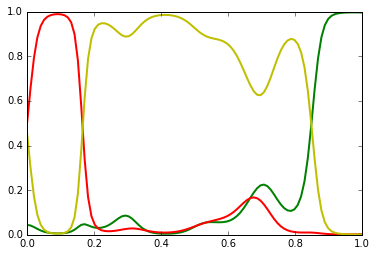

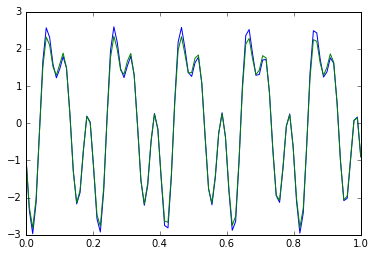

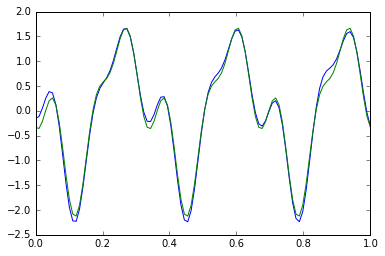

In [9]:
#% evaluate predictions


plt.figure()
plt.plot(X, g_softmax, 'g', lw=2)
plt.plot(X, h_softmax, 'r', lw=2)
plt.plot(X, k_softmax, 'y', lw=2)

mug, varg = m.predict_g(X)
muh, varh = m.predict_h(X)
muk, vark = m.predict_k(X)

muf,  varf  = m.predict_f(X)
muf2, varf2 = m.predict_f2(X)

#%
mug_softmax, muh_softmax, muk_softmax = softmax(mug,muh,muk)
plt.figure()
plt.plot(X, mug_softmax, 'g', lw=2)
#plt.plot(X, logistic(mu + 2*np.sqrt(var)), 'g--')
#plt.plot(X, logistic(mu - 2*np.sqrt(var)), 'g--')


#plt.figure()
plt.plot(X, muh_softmax, 'r', lw=2)
plt.plot(X, muk_softmax, 'y', lw=2)
#plt.plot(X, mu + 2*np.sqrt(var), 'm--')
#plt.plot(X, mu - 2*np.sqrt(var), 'm--')


plt.figure()
plt.plot(X,muf,'b')
plt.plot(X,f,'g')

plt.figure()
plt.plot(X,muf2,'b')
plt.plot(X,f2,'g')


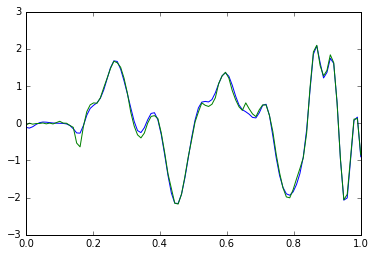

In [10]:
#%%
muf, var = m.predict_f(X)
muf2, var = m.predict_f2(X)
plt.figure()
plt.plot(X, muf*mug_softmax + 0*muh_softmax + muf2*muk_softmax, 'b')
plt.plot(X, y, 'g')